# Training With Transfer Learning
It's time to train the CNN. We will be using transfer learning - we'll take an existing, pretrained model and replace the fully connected layer. The model we'll be using is resnet50 model

We will train this model using mini-batch gradient descent and allow fine-tuning (allowing the bottleneck layers to be updated with each iteration).

In this notebook, we use PyTorch to train the model. Let's import the necessary modules:

In [1]:
# NumPy and pandas for manipulating data
import numpy as np
import pandas as pd

# To make validation and training set
from sklearn.model_selection import train_test_split

# For training diagnostics later
import matplotlib as mpl
from matplotlib import pyplot as plt

# Necessary torch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

from torchvision import models

# Used to copy weights later
import copy

# Custom DataLoader class and transforms from dataloader.py
import dataloader
from dataloader import DataLoader

Let's also define some constants to use throughout the training process:

In [2]:
# Define run constants

# csv created in preprocessing that where all the images are
PATHS_FILE = '../database/cropped/path_labels.csv' 
# file from raw data that tells all the class names (alphabetized)
ITEM_NAMES_FILE = '../database/raw/food-items.txt'

SEED = 17               # Seed for train_test_split 

IMAGE_SIZE = 224        # Size of input images expected by base model
BATCH_SIZE = 8          # Size of each batch 
N_EPOCHS = 100          # Number of epochs to train for
LEARNING_RATE = 1e-4    # Initial learning rate
STEP_SIZE = 7           # Number of epochs before one step for exponential decay
GAMMA = 0.1             # Amount to reduce learning rate by 

RUN_NAME = "batch_size-{}n_epochs-{}learning_rate-{}step_size-{}gamma-{}"\
    .format(BATCH_SIZE, N_EPOCHS, LEARNING_RATE, STEP_SIZE, GAMMA)

The data is located in `../database/cropped`. We'll load it using our `DataLoader` class. 
The `DataLoader` class has a function `DataLoader.get_data()` which returns a generator that returns data in batches.

In [3]:
# Load data...
# Read in item names 
with open(ITEM_NAMES_FILE) as f:
    item_names = f.read().splitlines()

# Count the number of items
n_classes = len(item_names)

# Make dictionaries to turn string labels into indicies and back
label_dict_itos = dict(zip(range(0, n_classes), item_names))
label_dict_stoi = dict(zip(item_names, range(0, n_classes)))

# Read csv (we made this in the preprocessing step).
df = pd.read_csv(PATHS_FILE)

# Get file paths from DataFrame.
file_paths = df['cropped_path'].values

# Get labels as integer indicies
labels = df['label'].map(label_dict_stoi).values

# Split into test/validation sets 
(file_paths_train, file_paths_valid, 
    labels_train, labels_valid)  = train_test_split(
                                    file_paths,
                                    labels,
                                    stratify=labels,
                                    test_size=0.2,
                                    random_state=SEED)

# List transformations (these are defined in dataloader.py)
transforms = [
#     (lambda x: x,                          {}),
    (dataloader.apply_blur,                {}),
    (dataloader.apply_brightness,          {}),
    (dataloader.apply_color_jitter,        {}),
    (dataloader.apply_sp_noise,            {}),
    (dataloader.apply_gauss_noise,         {}),
    (dataloader.apply_affine,              {}),
    (lambda img: dataloader.apply_color_jitter(dataloader.apply_affine(img)), {})
]

# Create data loader (once again, defined in dataloader.py)
data_loader_train = DataLoader(file_paths_train, labels_train, 
                            batch_size=BATCH_SIZE, 
                            image_size=(IMAGE_SIZE, IMAGE_SIZE), 
                            transforms=transforms)

data_loader_valid = DataLoader(file_paths_valid, labels_valid, 
                            batch_size=BATCH_SIZE, 
                            image_size=(IMAGE_SIZE, IMAGE_SIZE), 
                            transforms=[])

dataloaders = {'train': data_loader_train, 'valid': data_loader_valid}
dataset_sizes = {phase: dataloaders[phase].shape[0] for phase in dataloaders}

Let's create a function to train our model using PyTorch:

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    """ Train a model and return training history and the trained model.
    model               (torch.nn.Model): PyTorch model to train.
    
    criterion    (torch.nn.modules.loss): PyTorch loss function to optimize for.
    
    optimizer              (torch.optim): PyTorch optimizer to use when optimizing loss.
    
    scheduler (torch.optim.lr_scheduler): PyTorch scheduler to schedule the learning rate.
    
    num_epochs                     (int): Number of epochs to train for.
    """
    # Initialize the best weights.
    # We will be keeping track of the best model throughout training
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Lists to keep trach of the changes in loss and accuracy
    train_loss_record = []
    valid_loss_record = []

    train_acc_record = []
    valid_acc_record = []

    # Current epoch loss and accuracy
    epoch_loss = 0
    epoch_acc = 0 

    # Run for num_epochs epochs
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Do training phase and testing phase
        for phase in ['train', 'valid']:
            # Take a step for the scheduler if we're training
            if phase == 'train':
                if scheduler is not None:
                    scheduler.step(epoch_loss)
                model.train(True)
            else:
                model.train(False)

            # Keep track of the loss and accuracy across batches for this epoch
            running_loss = 0.0
            running_corrects = 0

            # Get the data from our DataLoader class
            for data in dataloaders[phase].get_data():
                inputs, labels = data

                # Use PyTorch standard [batch_size, channel, height, width] to make tensors
                inputs = torch.tensor([[inp[:, :, 0], 
                                        inp[:, :, 1], 
                                        inp[:, :, 2]] for inp in inputs])\
                    .type_as(torch.FloatTensor())
                
                # Make tensors from labels too
                labels = torch.tensor(labels).type_as(torch.LongTensor())
                labels = labels.view(-1)

                # Wrap the Tensors in Variables
                inputs, labels = Variable(inputs), Variable(labels)

                # Reset the optimizer's gradient (some optimizers use previous gradients)
                optimizer.zero_grad()

                # Get the outputs (logits) from the model
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1) 
                loss = criterion(outputs, labels)
                
                # Calculate gradient and perform backpropagation if training
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # Keep track of loss and accuracy for this epoch
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Calculate total loss and accuracy over the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = float(running_corrects) / dataset_sizes[phase]

            # Print and record the running loss and accuracy
            print('{} Loss : {:.4f} Acc : {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'train':
                train_loss_record.append(epoch_loss)
                train_acc_record.append(epoch_acc)
            else:
                valid_loss_record.append(epoch_loss)
                valid_acc_record.append(epoch_acc)

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        # Every 10 epochs, save a checkpoint model
        if (epoch % 10 == 0):
            checkpoint_path = './checkpoints/checkpoint' + RUN_NAME + str(epoch) + '.pt'
            torch.save(model, checkpoint_path)
            print("Saved checkpoint: {}".format(checkpoint_path))
    
    # Load the best model
    model.load_state_dict(best_model_wts)
    
    # Return the model along with the training and validation history
    return model, train_loss_record, valid_loss_record, train_acc_record, valid_acc_record

We need to define the architecture of our model. We take a base model and add our own fully connected layer:

In [5]:
class TransferModel(nn.Module):
    def __init__(self, base_model, n_classes):
        super(TransferModel, self).__init__()
        # Remove the fc layer
        self.base_layer = nn.Sequential(*list(base_model.children())[:-1])
    
        # Create our own fully connected layer
        self.fc = nn.Linear(base_model.fc.in_features, n_classes)
    
    def forward(self, inputs):
        # Connect the bottleneck layers with our fully connected layer 
        x = self.base_layer(inputs)
        x = x.view(x.size(0), -1)

        x = self.fc(x)
        return x

Now, we create and train the model. 

In [6]:
## Create a transfer learning model with resnet as the base
resnet_model = models.resnet50(pretrained=True)
transfer_model = TransferModel(resnet_model, n_classes)

# Use cross entropy loss
criterion = nn.CrossEntropyLoss()

# SGD optimizer; initialize learning rate to LEARNING_RATE
optimizer_conv = optim.SGD(transfer_model.parameters(), lr=LEARNING_RATE, 
                                momentum=0.9, weight_decay=0.001)

# Decrease learning rate by GAMMA for every STEP_SIZE steps
scheduler =  lr_scheduler.StepLR(optimizer_conv, step_size=STEP_SIZE, gamma=GAMMA)

# Call the training function
(transfer_model, train_loss_record, valid_loss_record, 
    train_acc_record, valid_acc_record) = train_model(transfer_model, 
                        criterion, optimizer_conv, scheduler, num_epochs=N_EPOCHS)

Epoch 0/99
----------
train Loss : 3.9394 Acc : 0.0362
valid Loss : 3.7574 Acc : 0.1157


/home/jshuai/anaconda3/envs/food-identifier/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type TransferModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Saved checkpoint: ./checkpoints/checkpointbatch_size-8n_epochs-100learning_rate-0.0001step_size-7gamma-0.10.pt
Epoch 1/99
----------
train Loss : 3.7876 Acc : 0.0888
valid Loss : 3.5674 Acc : 0.1157
Epoch 2/99
----------
train Loss : 3.6375 Acc : 0.1198
valid Loss : 3.3332 Acc : 0.2397
Epoch 3/99
----------
train Loss : 3.4915 Acc : 0.1911
valid Loss : 3.1004 Acc : 0.3471
Epoch 4/99
----------
train Loss : 3.2957 Acc : 0.2510
valid Loss : 2.8398 Acc : 0.4959
Epoch 5/99
----------
train Loss : 3.1479 Acc : 0.3130
valid Loss : 2.5723 Acc : 0.5413
Epoch 6/99
----------
train Loss : 2.9696 Acc : 0.3771
valid Loss : 2.3281 Acc : 0.6033
Epoch 7/99
----------
train Loss : 2.7886 Acc : 0.4318
valid Loss : 2.1067 Acc : 0.6446
Epoch 8/99
----------
train Loss : 2.6556 Acc : 0.4855
valid Loss : 1.9434 Acc : 0.6942
Epoch 9/99
----------
train Loss : 2.4838 Acc : 0.5052
valid Loss : 1.7504 Acc : 0.6818
Epoch 10/99
----------
train Loss : 2.3321 Acc : 0.5341
valid Loss : 1.5703 Acc : 0.7190
Saved ch

train Loss : 0.2979 Acc : 0.9370
valid Loss : 0.3637 Acc : 0.8884
Epoch 83/99
----------
train Loss : 0.3192 Acc : 0.9329
valid Loss : 0.3489 Acc : 0.9050
Epoch 84/99
----------
train Loss : 0.3018 Acc : 0.9339
valid Loss : 0.3323 Acc : 0.8802
Epoch 85/99
----------
train Loss : 0.3048 Acc : 0.9318
valid Loss : 0.3587 Acc : 0.8884
Epoch 86/99
----------
train Loss : 0.3408 Acc : 0.9225
valid Loss : 0.3578 Acc : 0.8926
Epoch 87/99
----------
train Loss : 0.2843 Acc : 0.9535
valid Loss : 0.3670 Acc : 0.8678
Epoch 88/99
----------
train Loss : 0.2901 Acc : 0.9421
valid Loss : 0.3396 Acc : 0.8884
Epoch 89/99
----------
train Loss : 0.3250 Acc : 0.9298
valid Loss : 0.3350 Acc : 0.9008
Epoch 90/99
----------
train Loss : 0.2769 Acc : 0.9442
valid Loss : 0.3494 Acc : 0.8884
Saved checkpoint: ./checkpoints/checkpointbatch_size-8n_epochs-100learning_rate-0.0001step_size-7gamma-0.190.pt
Epoch 91/99
----------
train Loss : 0.2813 Acc : 0.9442
valid Loss : 0.3627 Acc : 0.8843
Epoch 92/99
---------

Our model is finally done training. Let's graph the training record:

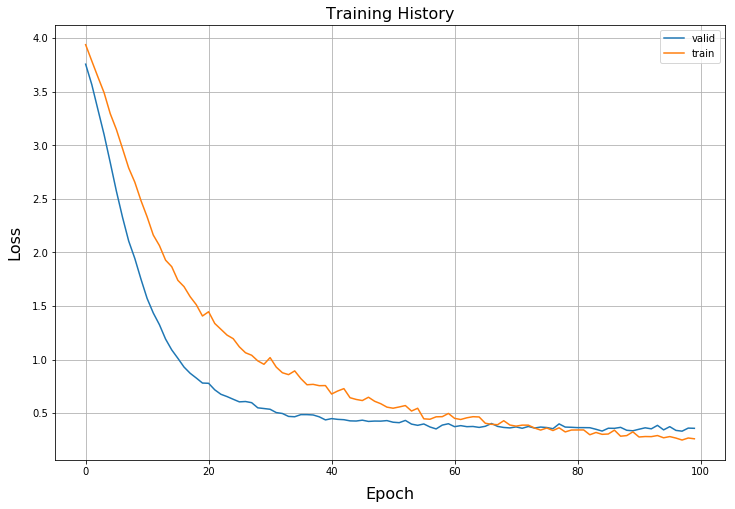

In [7]:
# Plot the loss history
x = range(N_EPOCHS)

plt.figure(figsize=(12, 8))
plt.plot(x, valid_loss_record, label='valid')
plt.plot(x, train_loss_record, label='train')

plt.title("Training History", fontsize=16)
plt.ylabel("Loss", fontsize=16, labelpad=10)
plt.xlabel("Epoch", fontsize=16, labelpad=10)
plt.legend()
plt.grid(axis='both')
plt.show()

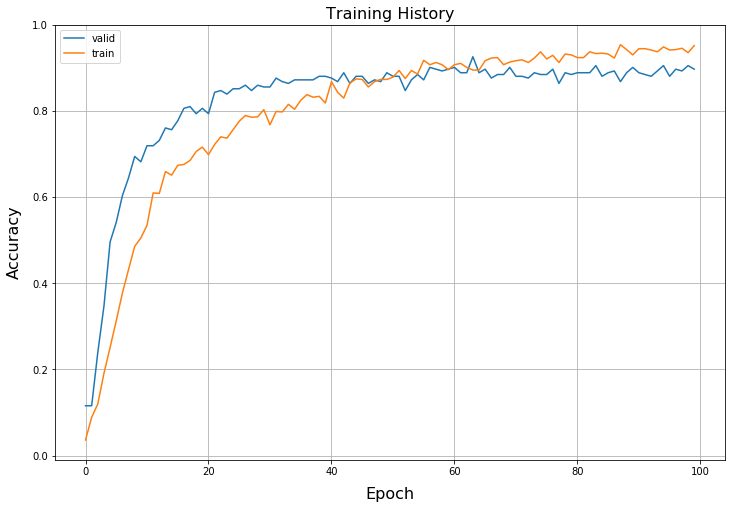

In [8]:
# Plot the accuracy history
x = range(N_EPOCHS)

plt.figure(figsize=(12, 8))
plt.plot(x, valid_acc_record, label='valid')
plt.plot(x, train_acc_record, label='train')

plt.title("Training History", fontsize=16)
plt.ylabel("Accuracy", fontsize=16, labelpad=10)
plt.xlabel("Epoch", fontsize=16, labelpad=10)
plt.legend()
plt.grid(axis='both')
plt.show()

We can see that the best validation accuracy goes up to around ~92.6%. Although it may seem strange that the training loss is often higher than the validation loss, it makes sense considering the transformations we apply on the training set.

Let's look at which classes we did well on:

In [9]:
# Make results DataFrame so that we can figure out where we did well
truth_hist = []
preds_hist = []
inputs_hist = []
for inputs, labels in dataloaders['valid'].get_data():
    inputs_hist.extend(inputs)
    inputs = torch.tensor([[inp[:, :, 0], 
                            inp[:, :, 1], 
                            inp[:, :, 2]] 
                            for inp in inputs])\
                            .type_as(torch.FloatTensor())

    probs = transfer_model(inputs)
    preds = np.argmax(probs.data.numpy(), axis=1)
    preds_hist.extend(preds)
    truth_hist.extend(labels)


result_df = pd.DataFrame()
result_df['truth_code'] = truth_hist
result_df['preds_code'] = preds_hist
result_df['image'] = inputs_hist
result_df['correct'] = result_df['truth_code'] == result_df['preds_code']
result_df['label'] = result_df['truth_code'].map(label_dict_itos)
result_df['guessed'] = result_df['preds_code'].map(label_dict_itos)

accuracy = result_df['correct'].mean()
group_accuracy = result_df.groupby('label')['correct'].mean().sort_values()

print("Accuracy: {}".format(accuracy))
group_accuracy

Accuracy: 0.9256198347107438


label
celery               0.500000
garlic               0.666667
potato               0.666667
thyme                0.750000
bacon                0.750000
chicken_breast       0.750000
basil                0.750000
mushroom             0.750000
ginger               0.750000
carrot               0.750000
chickpeas            0.750000
eggs                 0.800000
bell_pepper          0.800000
chicken_wing         0.833333
bananas              0.875000
pinto_beans          1.000000
parsley              1.000000
parmesan_cheese      1.000000
nutmeg               1.000000
pasta                1.000000
pork                 1.000000
red_onion            1.000000
rice                 1.000000
rosemary             1.000000
salmon               1.000000
spinach              1.000000
spring_onion         1.000000
strawberries         1.000000
tilapia              1.000000
pork_ribs            1.000000
mozzarella_cheese    1.000000
apples               1.000000
lettuce              1.000000
aspa

Let's look at some of the misclassified images, and what the model mistakened them for:

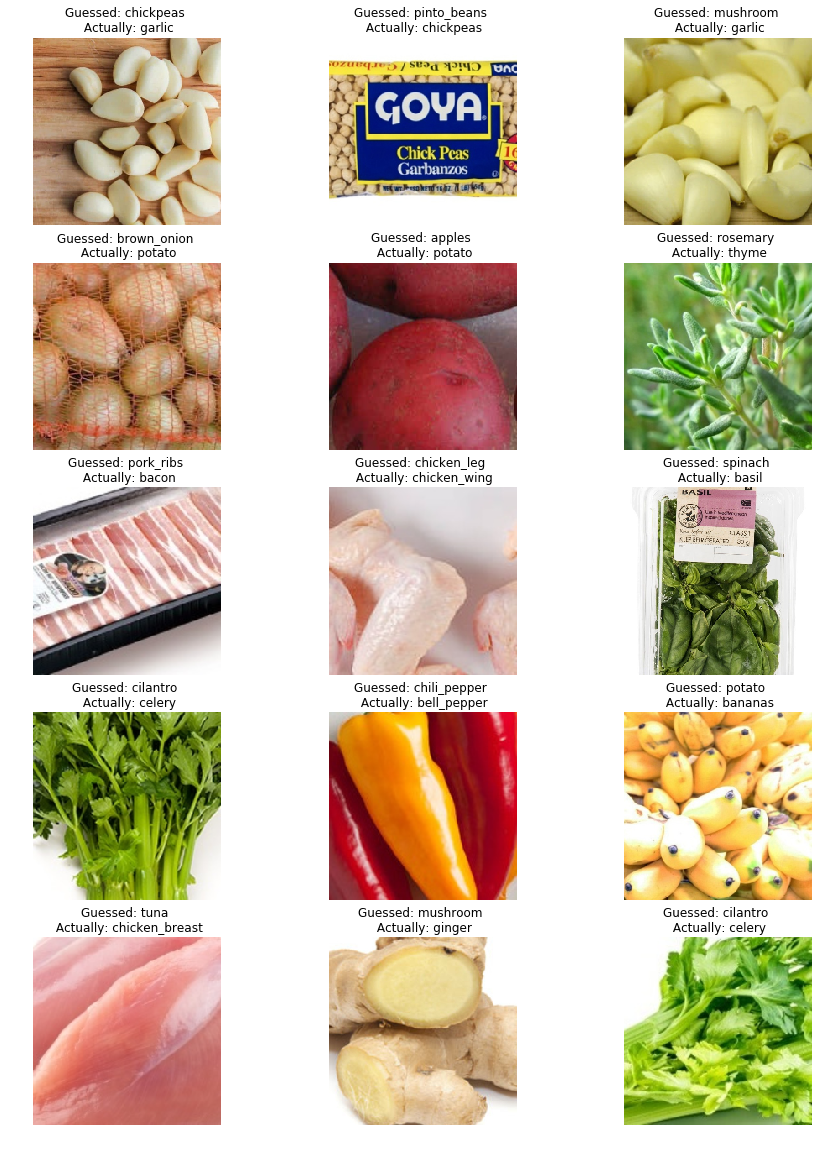

In [10]:
plt.figure(figsize=(15, 20))

incorrect_df = result_df[result_df['correct'] == False].sample(15).reset_index()
for i, row in incorrect_df.iterrows():
    plt.subplot(5, 3, i + 1)
    plt.imshow(row['image'])
    plt.title("Guessed: {} \n Actually: {}".format(row['guessed'], row['label']))
    plt.axis('off')